# Dataset Exploration

## Imports and Data Loading

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../")
from src.data.preprocessing import preprocess_text
from tqdm import tqdm
import datetime
from datetime import datetime, timedelta
import yfinance as yf
from pandarallel import pandarallel
import seaborn as sns
pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [18]:
raw_data = pd.read_pickle("../data/raw/motley-fool-data.pkl")
df = raw_data.copy()
df

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...
...,...,...,...,...,...
18750,"Nov 9, 2021, 1:00 p.m. ET",NYSE: SWX,2021-Q3,SWX,Prepared Remarks:\nOperator\nLadies and gentle...
18751,"Nov 18, 2021, 12:00 p.m. ET",NYSE: PNNT,2021-Q4,PNNT,"Prepared Remarks:\nOperator\nGood morning, and..."
18752,"Feb 08, 2022, 11:00 a.m. ET",NYSE: TDG,2022-Q1,TDG,Prepared Remarks:\nOperator\nThank you for sta...
18753,"Feb 28, 2022, 4:30 p.m. ET",NASDAQ: DVAX,2021-Q4,DVAX,"Prepared Remarks:\nOperator\nGood day, ladies ..."


In [19]:
# Only keep rows containing 'NASDAQ' or 'NYSE' (this represents 99.8% of the dataset)

nasdaq_mask = df['exchange'].str.contains('NASDAQ')
nyse_mask = df['exchange'].str.contains('NYSE')

df.loc[nasdaq_mask, 'exchange'] = 'NASDAQ'
df.loc[nyse_mask, 'exchange'] = 'NYSE'

# Drop others exchange
df = df[(nasdaq_mask | nyse_mask)]

# Clean the tickers
df.loc[:, 'ticker'] = df['ticker'].str.replace(r')', '')

# Clean quarters
df.loc[:, 'q'] = df.q.apply(lambda q: q[-2:])

In [20]:
# Clean the dates

# Some dates are lists where the date is the last element
def replace_with_last(lst):
    if isinstance(lst, list) and len(lst) > 0:
        return lst[-1]
    elif lst == '':
        return None
    else:
        return lst

# Apply the function to the column
df.loc[:, 'date'] = df['date'].apply(replace_with_last)
df = df.dropna()

# Remove ET which is not a timezone and present in all dates
df.loc[:, 'date'] = df['date'].apply(lambda q: str(q[:-3]))

df['date'] = pd.to_datetime(df["date"], errors="coerce", format="mixed")
df = df.dropna()
df.loc[:, 'year'] = df.date.dt.year.astype('Int64')
df['time'] = df.date.dt.time

In [21]:
df['before'] = df['date'].dt.time < pd.to_datetime('09:30').time()
df['after'] = df['date'].dt.time >= pd.to_datetime('16:00').time()

In [57]:
# Alternatively, if both columns contain boolean values, you can use the any() function
df = df[df[['before', 'after']].any(axis=1)]

df = df[~((df['date'].dt.time < pd.to_datetime('09:30').time()) & (df['date'].dt.weekday == 0))]
df = df[~((df['date'].dt.time >= pd.to_datetime('16:00').time()) & (df['date'].dt.weekday == 4))]

In [58]:
df = df.drop_duplicates(subset=['ticker', 'date', 'q'])

In [59]:
first_date = datetime(2017, 11, 3)
last_date = datetime(2023, 2, 22)

In [60]:
import yfinance as yf

# Ticker symbol for S&P 500
ticker = "^GSPC"

# Fetch the S&P 500 data
sp500 = yf.Ticker(ticker)
data_sp500 = sp500.history(period="1w", start=first_date - timedelta(days=90), end=last_date + timedelta(days=1))

data_sp500 = data_sp500.reset_index()
data_sp500['Date'] = data_sp500.Date.dt.tz_localize(None)
data_sp500

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-08-07,2477.139893,2480.949951,2475.879883,2480.909912,2935130000,0.0,0.0
1,2017-08-08,2478.350098,2490.870117,2470.320068,2474.919922,3347480000,0.0,0.0
2,2017-08-09,2465.350098,2474.409912,2462.080078,2474.020020,3310960000,0.0,0.0
3,2017-08-10,2465.379883,2465.379883,2437.750000,2438.209961,3635820000,0.0,0.0
4,2017-08-11,2441.040039,2448.090088,2437.850098,2441.320068,3161830000,0.0,0.0
...,...,...,...,...,...,...,...,...
1391,2023-02-15,4119.500000,4148.109863,4103.979980,4147.600098,4075980000,0.0,0.0
1392,2023-02-16,4114.750000,4136.540039,4089.489990,4090.409912,4143660000,0.0,0.0
1393,2023-02-17,4077.389893,4081.510010,4047.949951,4079.090088,4045480000,0.0,0.0
1394,2023-02-21,4052.350098,4052.350098,3995.189941,3997.340088,4121590000,0.0,0.0


In [61]:
def find_trend_sp500(s, data_sp500):
    temp = data_sp500[((s['date'] - timedelta(days=90) < data_sp500['Date']) & (data_sp500['Date'] < s['date'] - timedelta(days=1)))]
    last_price = temp.iloc[-1].Close
    price_1week = temp.iloc[-6].Close
    price_1month = temp.iloc[-20].Close
    price_3month = temp.iloc[0].Close


    change_1week = (last_price - price_1week) / price_1week
    change_1month = (last_price - price_1month) / price_1month
    change_3month = (last_price - price_3month) / price_3month
    return change_1week, change_1month, change_3month

In [62]:
past_sp500 = df.parallel_apply(find_trend_sp500, args=(data_sp500, ), axis=1)

In [63]:
df[['change_sp500_1week','change_sp500_1month','change_sp500_3month']] = past_sp500.apply(pd.Series)
df = df.dropna()

In [84]:
# Ticker symbol for 10-year Treasury Note as a proxy for interest rates
ticker = "^TNX"

# Fetch the S&P 500 data
interest_rates = yf.Ticker(ticker)
data_interest_rates = interest_rates.history(period="1w", start=first_date - timedelta(days=90), end=last_date + timedelta(days=1))
print(data_interest_rates)
data_interest_rates = data_interest_rates.reset_index()
data_interest_rates['Date'] = data_interest_rates.Date.dt.tz_localize(None)

                            Open   High    Low  Close  Volume  Dividends  \
Date                                                                       
2017-08-07 00:00:00-05:00  2.276  2.276  2.253  2.257       0        0.0   
2017-08-08 00:00:00-05:00  2.260  2.291  2.253  2.283       0        0.0   
2017-08-09 00:00:00-05:00  2.225  2.249  2.212  2.241       0        0.0   
2017-08-10 00:00:00-05:00  2.241  2.241  2.210  2.212       0        0.0   
2017-08-11 00:00:00-05:00  2.199  2.222  2.182  2.189       0        0.0   
...                          ...    ...    ...    ...     ...        ...   
2023-02-15 00:00:00-06:00  3.749  3.822  3.749  3.809       0        0.0   
2023-02-16 00:00:00-06:00  3.803  3.869  3.793  3.843       0        0.0   
2023-02-17 00:00:00-06:00  3.886  3.900  3.824  3.828       0        0.0   
2023-02-21 00:00:00-06:00  3.894  3.962  3.881  3.955       0        0.0   
2023-02-22 00:00:00-06:00  3.927  3.951  3.890  3.923       0        0.0   

           

In [88]:
def find_trend_interest(s, data_interest_rates):

    temp = data_interest_rates[((s['date'] - timedelta(days=90) < data_interest_rates['Date']) & (data_interest_rates['Date'] < s['date'] - timedelta(days=1)))]
    last_price = temp.iloc[-1].Close
    price_3month = temp.iloc[0].Close

    change_3month = (last_price - price_3month) / price_3month
    return last_price, change_3month

In [89]:
past_interest = df.parallel_apply(find_trend_interest, args=(data_interest_rates, ), axis=1)

In [91]:
df[['interest_rate','change_interest_rate_3month']] = past_interest.apply(pd.Series)
df = df.dropna()

In [69]:
def find_past_price(s):
    tickerSymbol = s['ticker']
    tickerData = yf.Ticker(tickerSymbol)
    success = True
    change_1week = None
    change_1month = None
    change_3month = None
    if s['before']:
        start = s['date'].date() - timedelta(days=90)
        end = s['date'].date() # - timedelta(days=1)
        tickerDf = tickerData.history(period='1d', start=start, end=end)
        if len(tickerDf) < 30:
            success = False

        else:

            price_before = tickerDf.iloc[-1].Close
            price_1week = tickerDf.iloc[-6].Close
            price_1month = tickerDf.iloc[-20].Close
            price_3month = tickerDf.iloc[0].Close


            div1week = tickerDf.iloc[-6:].Dividends.sum()
            change_1week = (price_before+div1week - price_1week) / price_1week
            div1month = tickerDf.iloc[-20:].Dividends.sum()
            change_1month = (price_before+div1month - price_1month) / price_1month
            div3month = tickerDf.iloc[0:].Dividends.sum()
            change_3month = (price_before+div3month - price_3month) / price_3month

    elif s['after']:
        start = s['date'].date() - timedelta(days=91)
        end = s['date'].date() + timedelta(days=1)
        tickerDf = tickerData.history(period='1d', start=start, end=end)
        if len(tickerDf) < 30:
            success = False

        else:
            price_before = tickerDf.iloc[-1].Close
            price_1week = tickerDf.iloc[-6].Close
            price_1month = tickerDf.iloc[-20].Close
            price_3month = tickerDf.iloc[0].Close

            div1week = tickerDf.iloc[-6:].Dividends.sum()
            change_1week = (price_before+div1week - price_1week) / price_1week
            div1month = tickerDf.iloc[-20:].Dividends.sum()
            change_1month = (price_before+div1month - price_1month) / price_1month
            div3month = tickerDf.iloc[0:].Dividends.sum()
            change_3month = (price_before+div3month - price_3month) / price_3month

    return success, change_1week, change_1month, change_3month

In [70]:
def find_price(s):
    tickerSymbol = s['ticker']
    tickerData = yf.Ticker(tickerSymbol)
    success = True
    change_during_news = None
    change_day_after = None
    change_week_after = None
    change_month_after = None
    if s['before']:
        start = s['date'].date() - timedelta(days=1)
        end = start + timedelta(days=31)
        tickerDf = tickerData.history(period='1d', start=start, end=end)
        if len(tickerDf) == 0:
            success = False

        else:
            price_before = tickerDf.iloc[0].Close
            price_after = tickerDf.iloc[1].Open
            price_next_day = tickerDf.iloc[1].Close
            price_next_week = tickerDf.iloc[6].Open
            price_next_month = tickerDf.iloc[-1].Open


            change_during_news = (price_after - price_before) / price_before
            change_day_after = (price_next_day - price_after) / price_after
            
            div1week = tickerDf.iloc[0:7].Dividends.sum()
            change_week_after = (price_next_week - price_after) / price_after
            
            div1month = tickerDf.iloc[0:].Dividends.sum()
            change_month_after = (price_next_month+div1month - price_after) / price_after

    elif s['after']:
        start = s['date'].date()
        end = start + timedelta(days=31)
        tickerDf = tickerData.history(period='1d', start=start, end=end)
        if len(tickerDf) == 0:
            success = False

        else:
            price_before = tickerDf.iloc[0].Close
            price_after = tickerDf.iloc[1].Open
            price_next_day = tickerDf.iloc[1].Close
            price_next_week = tickerDf.iloc[6].Open
            price_next_month = tickerDf.iloc[-1].Open

            
            change_during_news = (price_after - price_before) / price_before
            change_day_after = (price_next_day - price_after) / price_after

            div1week = tickerDf.iloc[0:7].Dividends.sum()
            change_week_after = (price_next_week - price_after) / price_after
            
            div1month = tickerDf.iloc[0:].Dividends.sum()
            change_month_after = (price_next_month - price_after) / price_after

    return success, change_during_news, change_day_after, change_week_after, change_month_after

In [71]:
past_price = df.parallel_apply(find_past_price, axis=1)

MSP: No timezone found, symbol may be delisted
MYOV: No timezone found, symbol may be delisted
ARNA: No timezone found, symbol may be delisted
COUP: No timezone found, symbol may be delisted
INT: No timezone found, symbol may be delisted
GWB: No timezone found, symbol may be delisted
FTCH: No timezone found, symbol may be delisted
SGEN: No timezone found, symbol may be delisted
SIVB: No price data found, symbol may be delisted (1d 2021-04-22 -> 2021-07-23)
CTIC: No timezone found, symbol may be delisted
XLNX: No timezone found, symbol may be delisted
MIME: No timezone found, symbol may be delisted
CHS: No timezone found, symbol may be delisted
SWCH: No timezone found, symbol may be delisted
ATC: No timezone found, symbol may be delisted
FLOW: Data doesn't exist for startDate = 1573621200, endDate = 1581397200
FOCS: No timezone found, symbol may be delisted
DSPG: No timezone found, symbol may be delisted
BCOR: No timezone found, symbol may be delisted
CDK: No timezone found, symbol may 

In [72]:
price = df.parallel_apply(find_price, axis=1)

MSP: No timezone found, symbol may be delisted
MYOV: No timezone found, symbol may be delisted
COUP: No timezone found, symbol may be delisted
ARNA: No timezone found, symbol may be delisted
INT: No timezone found, symbol may be delisted
GWB: No timezone found, symbol may be delisted
FTCH: No timezone found, symbol may be delisted
SGEN: No timezone found, symbol may be delisted
SIVB: No price data found, symbol may be delisted (1d 2021-07-22 -> 2021-08-22)
CTIC: No timezone found, symbol may be delisted
XLNX: No timezone found, symbol may be delisted
MIME: No timezone found, symbol may be delisted
CHS: No timezone found, symbol may be delisted
ATC: No timezone found, symbol may be delisted
SWCH: No timezone found, symbol may be delisted
FLOW: Data doesn't exist for startDate = 1581310800, endDate = 1583985600
FOCS: No timezone found, symbol may be delisted
BCOR: No timezone found, symbol may be delisted
DSPG: No timezone found, symbol may be delisted
CDK: No timezone found, symbol may 

In [73]:
df[['success','change_during_news','change_day_after','change_week_after', 'change_month_after']] = price.apply(pd.Series)
df = df.dropna()

In [74]:
df[['success2','past_change_1week','past_change_1month','past_change_3month']] = past_price.apply(pd.Series)
df = df.dropna()

In [75]:
df.columns

Index(['date', 'exchange', 'q', 'ticker', 'transcript', 'year', 'time',
       'before', 'after', 'change_sp500_1week', 'change_sp500_1month',
       'change_sp500_3month', 'interest_rate', 'change_interest_rate_3month',
       'success', 'change_during_news', 'change_day_after',
       'change_week_after', 'change_month_after', 'success2',
       'past_change_1week', 'past_change_1month', 'past_change_3month'],
      dtype='object')

In [76]:
df.drop(columns=['success', 'success2', 'before', 'after'], axis=1, inplace=True)

In [42]:
df["processed_transcript"] = df["transcript"].parallel_apply(preprocess_text)

In [93]:
df.to_csv("../data/processed/all_features.csv", index=True)

## Load the data and display some graphs

In [3]:
df = pd.read_csv("../data/processed/all_features.csv", index_col=0)

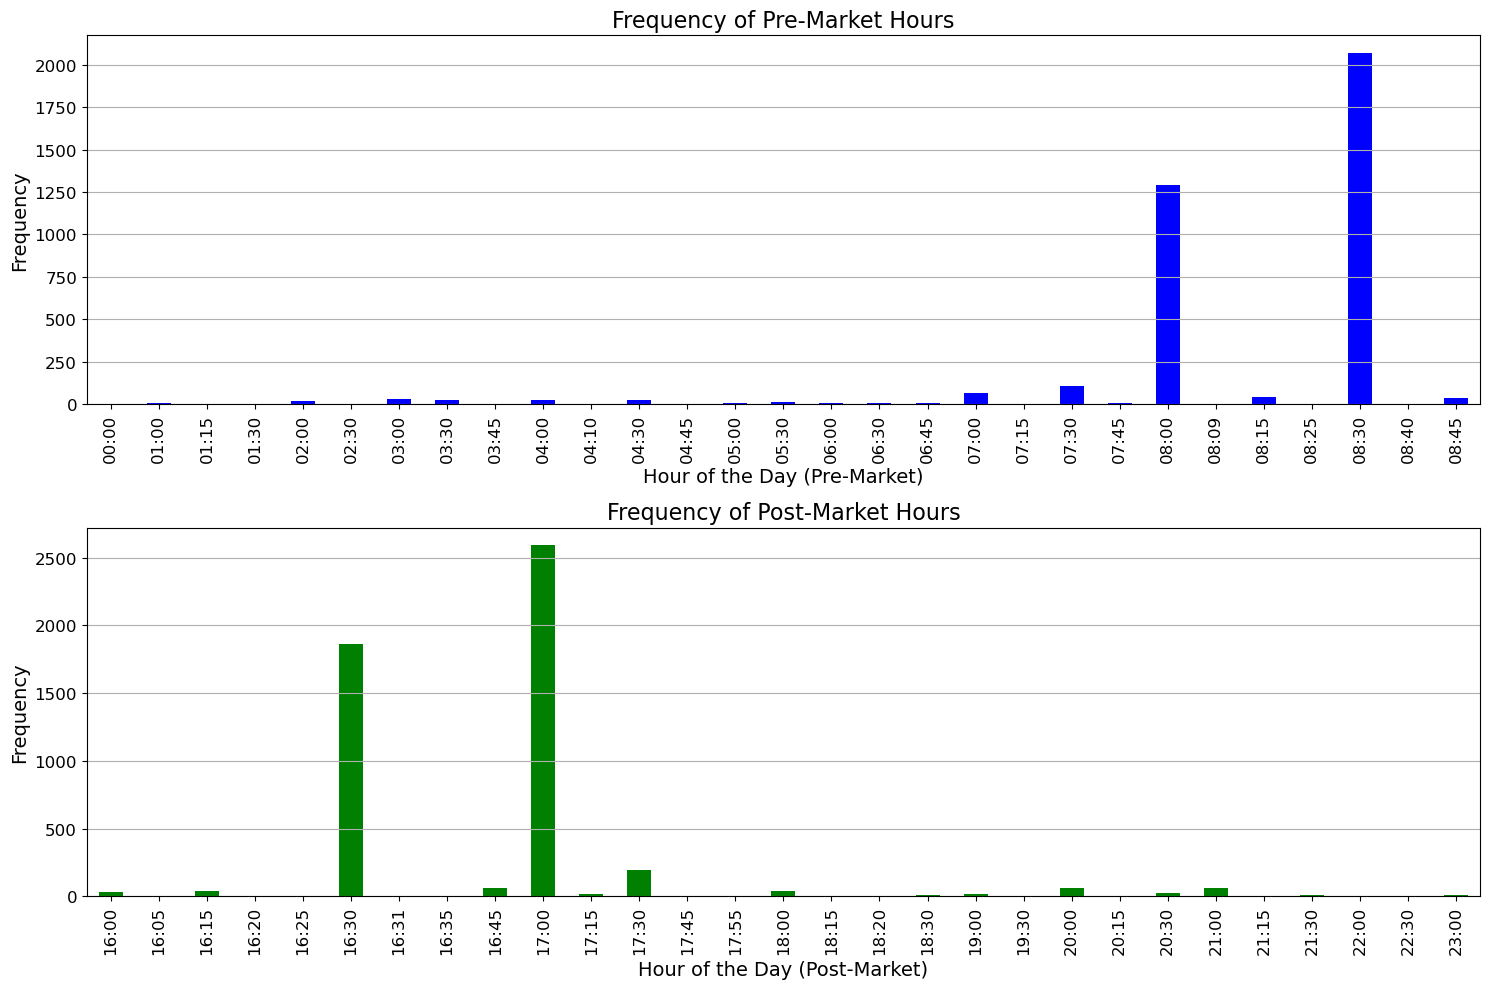

In [18]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

pre_market_hours = df[df['time'].dt.hour < 9]
post_market_hours = df[df['time'].dt.hour >= 16]

pre_market_counts = pre_market_hours['time'].dt.strftime('%H:%M').value_counts().sort_index()
post_market_counts = post_market_hours['time'].dt.strftime('%H:%M').value_counts().sort_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

pre_market_counts.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_xlabel('Hour of the Day (Pre-Market)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].set_title('Frequency of Pre-Market Hours', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='y')

post_market_counts.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_xlabel('Hour of the Day (Post-Market)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].set_title('Frequency of Post-Market Hours', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='y')

plt.tight_layout()
plt.savefig('frequency_hours.png')
plt.show()


/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


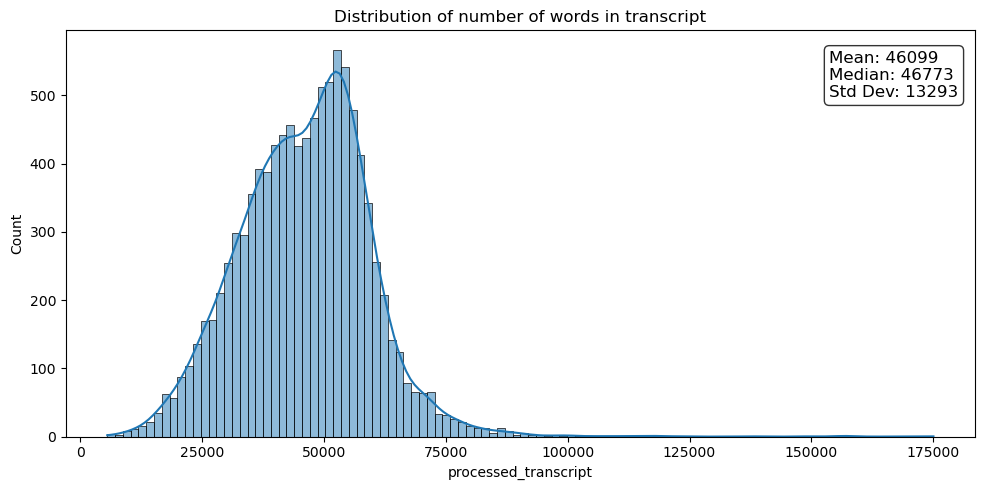

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df["processed_transcript"].apply(len), ax=ax, label="Number of words in transcript", kde=True)
ax.set_title("Distribution of number of words in transcript")

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = f'Mean: {mean_word_count:.0f}\nMedian: {median_word_count:.0f}\nStd Dev: {std_word_count:.0f}'
ax.text(0.84, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig('nb')
plt.show()

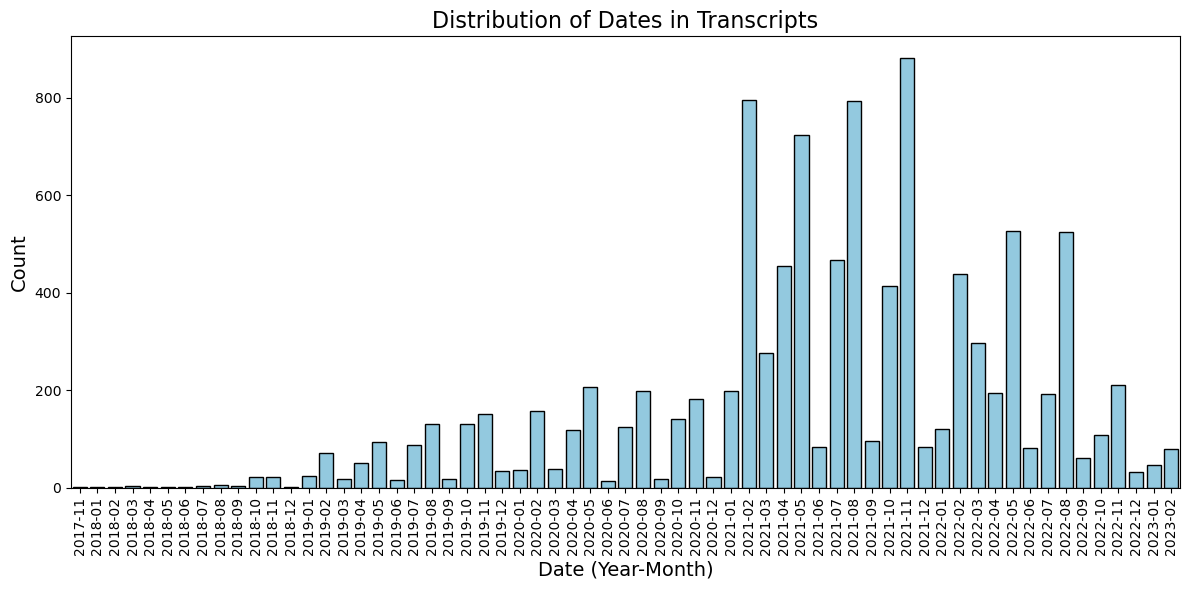

In [17]:
df['date'] = pd.to_datetime(df['date'])

df['year_month'] = df['date'].dt.to_period('M')

monthly_counts = df['year_month'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, ax=ax, color='skyblue', edgecolor='black')
ax.set_title("Distribution of Dates in Transcripts", fontsize=16)
ax.set_xlabel("Date (Year-Month)", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig('d')
plt.show()

In [47]:
vocab = dict()
for text in tqdm(df["processed_transcript"], total=len(df)):
    for word in text:
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10319/10319 [00:29<00:00, 350.91it/s]


In [48]:
print("Vocab size:", len(vocab))

Vocab size: 171828


In [16]:
print(df.transcript.iloc[0])

Prepared Remarks:
Operator
Good day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.
At this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.
Juliet Yang -- Senior Director of Investor Relations
Thank you, operator.
Please note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business and finan

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


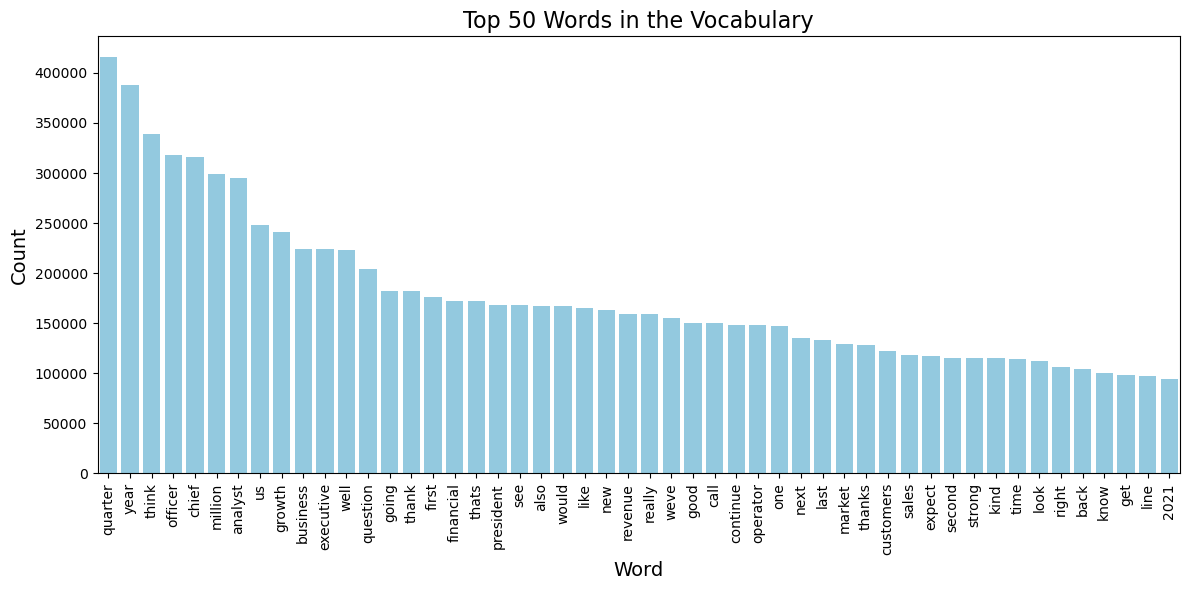

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

sns.barplot(x=[x[0] for x in sorted_vocab[:50]], y=[x[1] for x in sorted_vocab[:50]], ax=ax, color='skyblue')

plt.xticks(rotation=90)

ax.set_xlabel("Word", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Top 50 Words in the Vocabulary", fontsize=16)

plt.tight_layout()

plt.savefig('light')
plt.show()